# Задание
1) Выберите любой понравившийся вам набор данных по ссылке https://nijianmo.github.io/amazon/index.html, стоит обратить внимание на раздел "Small" subsets for experimentation, где представлены не самые большие датасеты (чтобы и в память поместился, и считался недолго).
2) Проведите базовый EDA - распределения рейтингов, количество уникальных товаров и т.д.
3) Отложите часть данных для тестирования. В рекомендательных системах для этого можно случайным образом “занулить” желаемый процент рейтингов в исходном датасете, чтобы получить “тренировочный набор”, и проверять качество ваших рекомендаций на этих уже не зануленных рейтингах. При этом, если у вас есть временная зависимость в данных, имеет смысл занулять рейтинги “из будущего”, чтобы обучаться на “исторических” покупках/просмотрах и т.д.
4) На основании вашего датасета постройте рекомендательную систему.
5) Оцените качество полученных рекомендаций, при помощи подходящих метрик (если вы использовали рейтинги, можно взять RMSE).

# Посмотрим на данные

In [50]:
# библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [51]:
# Сменим рабочую дирректорию для удобства
import os
os.chdir('/home/slawa/HDD/my_scripts/my_otus/ML_advanced/lesson_18/hw')

In [52]:
# Загрузка данных
raw_data_file_name = 'All_Beauty.csv'
raw_df = pd.read_csv(raw_data_file_name, delimiter=',', decimal='.', names=['item', 'user', 'rating', 'timestamp'])
raw_df

,item,user,rating,timestamp
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200
...,...,...,...,...
371340,B01HJEGTYK,A202DCI7TV1022,1.0,1500508800
371341,B01HJEGTYK,A3FSOR5IJOFIBE,5.0,1489622400
371342,B01HJEGTYK,A1B5DK6CTP2P24,5.0,1488326400
371343,B01HJEGTYK,A23OUYS5IRMJS9,2.0,1487635200


In [53]:
# проверяем на пустые значения
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   item       371345 non-null  object 
 1   user       371345 non-null  object 
 2   rating     371345 non-null  float64
 3   timestamp  371345 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ MB


In [54]:
# убираем дубликаты
raw_df.drop_duplicates(inplace=True)
raw_df

,item,user,rating,timestamp
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200
...,...,...,...,...
371340,B01HJEGTYK,A202DCI7TV1022,1.0,1500508800
371341,B01HJEGTYK,A3FSOR5IJOFIBE,5.0,1489622400
371342,B01HJEGTYK,A1B5DK6CTP2P24,5.0,1488326400
371343,B01HJEGTYK,A23OUYS5IRMJS9,2.0,1487635200


In [55]:
# может быть ситуация, что пользователь в одну метку времени выставил разные оценки одному и тому же предмету
# проверим
rating_count = raw_df.groupby(['timestamp', 'user', 'item']).count()
rating_count_error = rating_count.loc[rating_count['rating'] > 1, :]
rating_count_error

,,,rating
timestamp,user,item,
1120262400,AIBRTGBN07D6A,B0009MFZAE,2
1130630400,A2ML7RYN9VQPPK,B0009MFUN6,2
1245974400,A3R9H6OKZHHRJD,B000LIBUBY,2
1252627200,A154S5BSNCEJOD,B0002W30IA,2
1317513600,A2EHYCA29NSQLU,B004A7PB26,2
...,...,...,...
1520294400,A2MERYBWEV2PLQ,B00W259T7G,2
1521158400,A19647HABGFHHG,B00NE5Q9JO,2
1522368000,A3FAJ4P2GREPP9,B00W259T7G,2


In [56]:
# удалим ошибочные оценки
for timestamp, user, item in rating_count_error.index:
    idx = raw_df.loc[
        (raw_df['timestamp'] == timestamp) &\
        (raw_df['user'] == user) &\
        (raw_df['item'] == item),
        :
    ].index
    raw_df.drop(index=idx, inplace=True)
raw_df

,item,user,rating,timestamp
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200
...,...,...,...,...
371340,B01HJEGTYK,A202DCI7TV1022,1.0,1500508800
371341,B01HJEGTYK,A3FSOR5IJOFIBE,5.0,1489622400
371342,B01HJEGTYK,A1B5DK6CTP2P24,5.0,1488326400
371343,B01HJEGTYK,A23OUYS5IRMJS9,2.0,1487635200


In [57]:
print(f'Размер датасета: {raw_df.shape}')
print(f'Количество уникальных товаров: {len(raw_df["item"].unique())}')
print(f'Количество уникальных пользователей: {len(raw_df["user"].unique())}')
print(f'Уникальные оценки: {raw_df["rating"].unique()}')

Размер датасета: (362127, 4)
Количество уникальных товаров: 32586
Количество уникальных пользователей: 323995
Уникальные оценки: [1. 4. 5. 2. 3.]


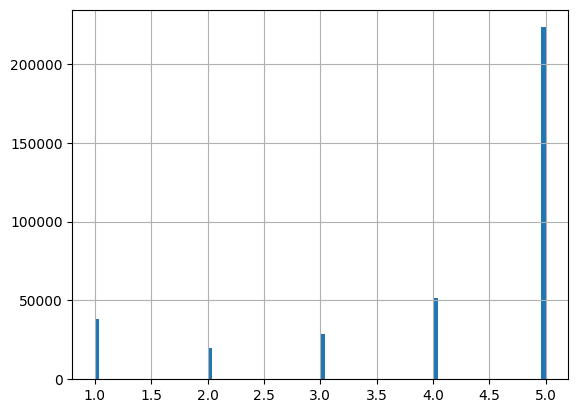

In [58]:
raw_df["rating"].hist(bins=100)
plt.show()

In [59]:
# отсортируем по временной метке
sort_raw_df = raw_df.sort_values(by=['timestamp'])
sort_raw_df.reset_index(inplace=True)
sort_raw_df

,index,item,user,rating,timestamp
0,256078,3317005939,AL2PQBKHP7LM4,5.0,947462400
1,261647,0061073717,ATKPYXA8XFKGJ,5.0,957571200
2,261646,0061073717,A2XMFX1BR0IJFJ,5.0,959990400
3,256161,B000050B62,A1U7T7UCCV3SBN,5.0,972777600
4,5299,B000050FDP,A3RVIXD86WUT1E,5.0,973987200
...,...,...,...,...,...
362122,371246,B01HHWQX8G,A32D5I46E15TEC,3.0,1538265600
362123,370903,B01HC6G4D6,A1RAXJN2Q4V20X,4.0,1538265600
362124,368798,B01GJQXRLC,A3ORA680FWE8SW,5.0,1538352000
362125,368687,B01GIYE88G,A3RTH0S9XVBPVK,5.0,1538352000


In [60]:
# делим датасет на train и test

# считаем индекс места разделения на две части
start_index = sort_raw_df.shape[0] * (1 - 0.2)

# отбираем данные для теста
test_df = sort_raw_df.loc[start_index:, ['user', 'item', 'rating']]

# зануляем данные в основном датасете, которые ранее отобрали
train_df = sort_raw_df.loc[:, ['user', 'item', 'rating']]
train_df.loc[start_index:, ['rating']] = 0.0
train_df


,user,item,rating
0,AL2PQBKHP7LM4,3317005939,5.0
1,ATKPYXA8XFKGJ,0061073717,5.0
2,A2XMFX1BR0IJFJ,0061073717,5.0
3,A1U7T7UCCV3SBN,B000050B62,5.0
4,A3RVIXD86WUT1E,B000050FDP,5.0
...,...,...,...
362122,A32D5I46E15TEC,B01HHWQX8G,0.0
362123,A1RAXJN2Q4V20X,B01HC6G4D6,0.0
362124,A3ORA680FWE8SW,B01GJQXRLC,0.0
362125,A3RTH0S9XVBPVK,B01GIYE88G,0.0


In [61]:
# Сохраняем собранные датасеты
train_df.to_csv('train_data.csv', decimal='.', sep=',', index=False)
test_df.to_csv('test_data.csv', decimal='.', sep=',', index=False)


# BaseLine
В качестве ориентира наполним нулевые оценки рандомными оценками.

In [62]:
# библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as RMSE
import os

In [63]:
# Сменим рабочую дирректорию для удобства
import os
os.chdir('/home/slawa/HDD/my_scripts/my_otus/ML_advanced/lesson_18/hw')

In [64]:
# загружаем датасеты
train_data = pd.read_csv('train_data.csv', decimal='.', delimiter=',')
test_data = pd.read_csv('test_data.csv', decimal='.', delimiter=',')

In [65]:
# инициализация случайного генератора
rnd_gen = np.random.default_rng(seed=100)

# получаем уникальные значения оценки, исключая ноль
rating = test_data['rating'].unique()
rating = rating[rating != 0.0]

In [66]:
# генерируем случайные рейтинги
test_data['random_rating'] = rnd_gen.choice(rating, size=(test_data.shape[0],))

In [67]:
# считаем метрику
rmse_metric = RMSE(test_data['rating'], test_data['random_rating'])
print(f'Качество предсказания: {rmse_metric}')

Качество предсказания: 2.2708368577505667


# Библиотека surprise

## SVD

In [68]:
# библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import root_mean_squared_error as RMSE
from surprise import SVD, Dataset, Reader

In [69]:
# Сменим рабочую дирректорию для удобства
import os
os.chdir('/home/slawa/HDD/my_scripts/my_otus/ML_advanced/lesson_18/hw')

In [70]:
# загружаем датасеты
train_data = pd.read_csv('train_data.csv', decimal='.', delimiter=',')
test_data = pd.read_csv('test_data.csv', decimal='.', delimiter=',')

In [71]:
# создаем модель
algo = SVD()

In [72]:
# создаем объект, использующийся для обучения модели
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1.0, 5.0), skip_lines=0)
dataset_train = Dataset.load_from_df(
    train_data.loc[:, ['user', 'item', 'rating']],
    reader=reader
)
X_train = dataset_train.build_full_trainset()

In [73]:
# обучаем алгоритм
algo.fit(X_train)

In [74]:
# получем массивы с предсказанной оценкой алгоритмом и реальными оценками пользователей, используя test_data
# отдельно собираем пользователей и предметы, о которых ничего ранее было неизвестно 
Y_true = []
Y_pred = []
new_users = []
new_items = []
for idx in test_data.index:
    user = test_data.loc[idx,'user']
    item = test_data.loc[idx,'item']
    rating_true = test_data.loc[idx,'rating']
    uid = ''
    iid = ''
    try:
        uid = X_train.to_inner_uid(user)
    except ValueError as ex:
        pass
    try:
        iid = X_train.to_inner_uid(user)
    except ValueError as ex:
        pass
    if uid == '':
        new_users.append(user)
        continue
    if iid == '':
        new_items.append(item)
        continue
    rating_pred= algo.predict(uid, iid).est
    Y_true.append(rating_true)
    Y_pred.append(rating_pred)

Y_true = np.array(Y_true)
Y_pred = np.array(Y_pred)

print(f'Всего данных: {len(Y_true)}')
print(f'Неизветстных пользователей: {len(new_users)}')
print(f'Неизветстных предметов: {len(new_items)}')

Всего данных: 72425
Неизветстных пользователей: 0
Неизветстных предметов: 0


In [75]:
# считаем метрику
rmse_metric = RMSE(Y_true, Y_pred)
print(f'Качество предсказания: {rmse_metric}')

Качество предсказания: 1.6179262323406618


## NMF

In [76]:
# библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import root_mean_squared_error as RMSE
from surprise import NMF, Dataset, Reader

In [77]:
# Сменим рабочую дирректорию для удобства
import os
os.chdir('/home/slawa/HDD/my_scripts/my_otus/ML_advanced/lesson_18/hw')

In [78]:
# загружаем датасеты
train_data = pd.read_csv('train_data.csv', decimal='.', delimiter=',')
test_data = pd.read_csv('test_data.csv', decimal='.', delimiter=',')

In [79]:
# создаем модель
algo = NMF()

In [80]:
# создаем объект, использующийся для обучения модели
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1.0, 5.0), skip_lines=0)
dataset_train = Dataset.load_from_df(
    train_data.loc[:, ['user', 'item', 'rating']],
    reader=reader
)
X_train = dataset_train.build_full_trainset()

In [81]:
# обучаем алгоритм
algo.fit(X_train)

In [82]:
# получем массивы с предсказанной оценкой алгоритмом и реальными оценками пользователей, используя test_data
# отдельно собираем пользователей и предметы, о которых ничего ранее было неизвестно 
Y_true = []
Y_pred = []
new_users = []
new_items = []
for idx in test_data.index:
    user = test_data.loc[idx,'user']
    item = test_data.loc[idx,'item']
    rating_true = test_data.loc[idx,'rating']
    uid = ''
    iid = ''
    try:
        uid = X_train.to_inner_uid(user)
    except ValueError as ex:
        pass
    try:
        iid = X_train.to_inner_uid(user)
    except ValueError as ex:
        pass
    if uid == '':
        new_users.append(user)
        continue
    if iid == '':
        new_items.append(item)
        continue
    rating_pred= algo.predict(uid, iid).est
    Y_true.append(rating_true)
    Y_pred.append(rating_pred)

Y_true = np.array(Y_true)
Y_pred = np.array(Y_pred)

print(f'Всего данных: {len(Y_true)}')
print(f'Неизветстных пользователей: {len(new_users)}')
print(f'Неизветстных предметов: {len(new_items)}')

Всего данных: 72425
Неизветстных пользователей: 0
Неизветстных предметов: 0


In [83]:
# считаем метрику
rmse_metric = RMSE(Y_true, Y_pred)
print(f'Качество предсказания: {rmse_metric}')

Качество предсказания: 1.6179262323406618
